# 準備（共通部分）

In [ ]:
import random
import numpy as np
import torch
import time # 計算時間計算用

def torch_fix_seed(seed=24):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import numpy as np
torch_fix_seed()
dataset = datasets.MNIST('./data', train=True, download=True)
x0 = dataset.data.reshape(60000,1,28,28) / 255.0
y0 = dataset.targets

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cn1 = nn.Conv2d(1, 20, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.cn2 = nn.Conv2d(20, 50, 5)
        self.fc1 = nn.Linear(50 * 8 * 8, 8)
        self.fc2 = nn.Linear(8, 8)
        self.fc3 = nn.Linear(8, 10)
    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = self.pool1(x)
        x = F.relu(self.cn2(x))
        x = x.view(len(x), -1) # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#パラメータの変更なし

In [ ]:
model1 = CNN().to(device)
optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

n = len(y0)
bs = 200
losses1 = []
epochs = 5

start = time.time() # 計測開始 

model1.train()
for j in range(epochs):
    idx = np.random.permutation(n)
    for i in range(0, n, bs):
        x = x0[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y = y0[idx[i:(i+bs) if (i+bs) < n else n]].to(device)    
        output = model1(x)
        loss = criterion(output,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses1.append(loss.item())
    print(j, loss.item())

time1 = time.time()-start
print("Calculate time",time1) # 計算時間を出力

0 0.25033944845199585
1 0.09344121068716049
2 0.06031305342912674
3 0.0903700739145279
4 0.04345123842358589
Calculate time 14.611348152160645


#パラメータの変更あり（初期の重みのみ変更）

In [ ]:
model2 = CNN()

# 変更用のTensor配列を作成
a = np.zeros((8,8))
a += 0.5
b = torch.from_numpy(a).to(torch.float32) # GPUに送るためfloat32に変更

print(b)
# 重みを強制的に変更
model2.fc2.weight.data = b
model2.to(device)

optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

n = len(y0)
bs = 200
losses2 = []
epochs = 5

start = time.time() # 計測開始

model2.train()
for j in range(epochs):
    idx = np.random.permutation(n)
    for i in range(0, n, bs):
        x = x0[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y = y0[idx[i:(i+bs) if (i+bs) < n else n]].to(device)    
        output = model2(x)
        loss = criterion(output,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses2.append(loss.item())
    print(j, loss.item())

time2 = time.time()-start
print("Calculate time", time2)

tensor([[0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000]])
0 1.3338737487792969
1 0.41922369599342346
2 0.1784450113773346
3 0.06598884612321854
4 0.03174225240945816
Calculate time 6.945463418960571


In [ ]:
b

tensor([[ 0.4390,  0.5026,  0.5855,  1.6633, -0.0603,  0.4993,  0.4879, -0.1181],
        [-0.1254,  0.5029,  0.3460,  0.5661, -0.1977,  0.5015,  0.6478,  1.2121],
        [ 0.4887,  0.4997,  0.2022,  0.3245,  0.4456,  0.4957,  0.5009,  0.6152],
        [-0.3484,  0.4979,  1.3411,  0.3434,  0.6682,  0.5064,  0.5668,  0.0519],
        [ 1.4579,  0.5058,  0.7893, -0.0137, -0.0726,  0.5069,  0.4347,  0.7641],
        [ 0.9523,  0.4987, -0.0222,  0.1446,  1.4233,  0.4990,  0.4014, -0.0046],
        [-0.1312,  0.4989, -0.1505,  0.6343,  0.9683,  0.5038,  0.5069,  0.7554],
        [ 0.3395,  0.4989,  0.6365,  0.1065,  0.1334,  0.4964,  0.5689,  0.6762]],
       device='cuda:0')

#パラメータの変更あり（毎回重みを変更）

In [ ]:
# 事前に作成した配列bを利用する
b = b.to(device) # 先ほどと違い毎回重みを更新するため、modelをまとめてGPUに送る作業を省略するために、事前に配列bをGPUに送る

model3 = CNN()

model3.to(device)

optimizer = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

n = len(y0)
bs = 200
losses3 = []
epochs = 5

start = time.time() # 計測開始

model3.train()
for j in range(epochs):
    idx = np.random.permutation(n)
    for i in range(0, n, bs):
        x = x0[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y = y0[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        model3.fc2.weight.data = b # 毎回重みを強制的に更新     
        output = model3(x)
        loss = criterion(output,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses3.append(loss.item())
    print(j, loss.item())

time3 = time.time()-start

print("Calculate time",time3)

0 1.2162532806396484
1 0.2943184971809387
2 0.09329080581665039
3 0.05544667690992355
4 0.12776750326156616
Calculate time 6.5374226570129395


#比較

## 正解率の比較

In [ ]:
tdataset = datasets.MNIST('./data', train=False, download=True)
xtest = tdataset.data.reshape(10000,1,28,28) / 255.0
ytest = tdataset.targets
model1.eval()
with torch.no_grad():
    y1 = model1(xtest.to(device))
    ans = torch.argmax(y1,1).to('cpu')
    print("normal",((ytest == ans).sum().float()/len(ans)).item())

model2.eval()
with torch.no_grad():
    y1 = model2(xtest.to(device))
    ans = torch.argmax(y1,1).to('cpu')
    print("updated initial value only",((ytest == ans).sum().float()/len(ans)).item())

model3.eval()
with torch.no_grad():
    y1 = model3(xtest.to(device))
    ans = torch.argmax(y1,1).to('cpu')
    print("updated every time",((ytest == ans).sum().float()/len(ans)).item())

normal 0.9789000153541565
updated initial value only 0.9728000164031982
updated every time 0.9757000207901001


## LOSS曲線の比較

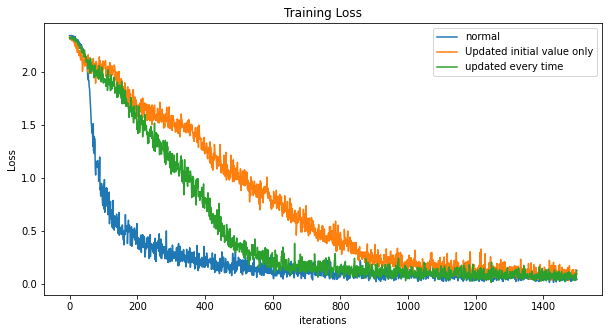

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses1,label="normal")
plt.plot(losses2,label="Updated initial value only")
plt.plot(losses3,label="updated every time")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 計算時間の比較

In [ ]:
print("normal",time1)
print("Updated initial value only",time2)
print("updated every time",time3)

normal 14.611348152160645
Updated initial value only 6.450014591217041
updated every time 6.5374226570129395


# 考察

・正解率およびLOSS曲線の比較からパラメタを強制的に変更しても学習することができることが分かった。

・正解率の比較からパラメータを強制的に変更しても正解率にはほとんど影響がないことがわかる。一方、LOSS曲線を確認するとパラメータを変化させなかった場合のほうがLOSSが小さくなる速度が速く、より効率的に計算できていることがわかる。

・計算時間に関してはほとんど差異がなかったが、パラメータを変更した二つのパターンのほうが、変更しなかった場合に比べ、0.1秒ほど遅くなることが分かったが、この順位は実行するたびに代わるため、ほぼ差がなかったと考えてよいと思われる。
